In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
# Define the input shape based on your dataset's image dimensions
input_shape = (48, 48, 1)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [3]:
dataset_path = "/kaggle/input/fer2013-cleaned-dataset/images1"
batch_size = 64

In [4]:
from keras.models import Sequential
import numpy as np
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
from keras.layers import Layer, Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, Dense
from keras.models import Model

class MultiHeadSelfAttention(Layer):
    def __init__(self, channels, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.channels = channels
        self.num_heads = num_heads

        # Linear transformations for queries, keys, and values for each head
        self.W_q = [Conv2D(channels // num_heads, (1, 1), padding='same') for _ in range(num_heads)]
        self.W_k = [Conv2D(channels // num_heads, (1, 1), padding='same') for _ in range(num_heads)]
        self.W_v = [Conv2D(channels // num_heads, (1, 1), padding='same') for _ in range(num_heads)]

        # Linear transformation for the output of attention heads
        self.W_o = Conv2D(channels, (1, 1), padding='same')

    def call(self, x):
        head_outputs = []
        for i in range(self.num_heads):
            q = self.W_q[i](x)
            k = self.W_k[i](x)
            v = self.W_v[i](x)

            # Perform self-attention for each head
            attention_weights = tf.nn.softmax(tf.matmul(q, k, transpose_b=True) / tf.math.sqrt(tf.cast(tf.shape(k)[-1], tf.float32)))
            head_output = tf.matmul(attention_weights, v)
            head_outputs.append(head_output)

        # Concatenate outputs from all heads
        multihead_output = tf.concat(head_outputs, axis=-1)

        # Linear transformation for the output of attention heads
        output = self.W_o(multihead_output)

        return output

def residual_block_with_multihead_attention(x, filters, kernel_size=(3, 3), stride=(1, 1), padding='same'):
    shortcut = x

    # First convolution layer
    x = Conv2D(filters, kernel_size, strides=stride, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Multi-Head Self-Attention layer
    x_att = MultiHeadSelfAttention(filters)(x)

    # Combine original features and attention features
    x = Add()([x, x_att])

    # Second convolution layer
    x = Conv2D(filters, kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)

    # Add the shortcut to the output
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

# Build the model with multi-head self-attention
def build_vgg_with_resnet_and_multihead_attention(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    # VGG-like convolutional layers with residual blocks and multi-head self-attention
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(input_layer)
    x = residual_block_with_multihead_attention(x, 64)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = residual_block_with_multihead_attention(x, 128)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = residual_block_with_multihead_attention(x, 256)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = residual_block_with_multihead_attention(x, 512)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Flatten and add fully connected layers
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(512, activation='relu')(x)

    # Output layer
    output_layer = Dense(num_classes, activation='softmax')(x)

    # Create and compile the model
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

# Define the number of classes in your dataset
num_classes = 7  # Assuming FER 2013 has 7 emotion classes

# Build the model with multi-head self-attention
model = build_vgg_with_resnet_and_multihead_attention(input_shape, num_classes)

# Compile the model with appropriate loss and optimizer


# Print a summary of the model architecture
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 48, 48, 64)           640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 48, 48, 64)           36928     ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 48, 48, 64)           256       ['conv2d_1[0][0]']            
 Normalization)                                                                               

In [6]:
train_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

train_data = train_data_generator.flow_from_directory(
    os.path.join(dataset_path, 'train'),
    color_mode='grayscale',
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_data = test_data_generator.flow_from_directory(
    os.path.join(dataset_path, 'test'),
    color_mode='grayscale',
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 28044 images belonging to 7 classes.
Found 7177 images belonging to 7 classes.


In [7]:
num_train_samples = 28044
num_test_samples = 7177

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [15]:
history = model.fit(
    train_data,
    steps_per_epoch=num_train_samples // batch_size,
    epochs=100,
    callbacks=[early_stopping],
    batch_size=batch_size,
    validation_data=test_data
)

Epoch 1/100
438/438 [==============================] - 65s 148ms/step - loss: 0.7355 - accuracy: 0.7228 - val_loss: 1.3097 - val_accuracy: 0.5821
Epoch 2/100
438/438 [==============================] - 64s 147ms/step - loss: 0.7077 - accuracy: 0.7322 - val_loss: 1.2218 - val_accuracy: 0.5838
Epoch 3/100
438/438 [==============================] - 64s 145ms/step - loss: 0.6710 - accuracy: 0.7481 - val_loss: 1.2862 - val_accuracy: 0.5722
Epoch 4/100
438/438 [==============================] - 64s 145ms/step - loss: 0.6423 - accuracy: 0.7590 - val_loss: 1.3675 - val_accuracy: 0.5756
Epoch 5/100
438/438 [==============================] - 64s 147ms/step - loss: 0.6056 - accuracy: 0.7730 - val_loss: 1.3719 - val_accuracy: 0.5803
Epoch 6/100
438/438 [==============================] - 64s 145ms/step - loss: 0.5799 - accuracy: 0.7835 - val_loss: 1.4318 - val_accuracy: 0.5715
Epoch 7/100
438/438 [==============================] - 64s 145ms/step - loss: 0.5658 - accuracy: 0.7897 - val_loss: 1.4194 -

In [19]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

# Build the model with multi-head self-attention
def build_vgg_with_resnet_and_multihead_attention(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    # VGG-like convolutional layers with residual blocks and multi-head self-attention
    x = Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(1e-4))(input_layer)
    x = residual_block_with_multihead_attention(x, 64)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = residual_block_with_multihead_attention(x, 128)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = residual_block_with_multihead_attention(x, 256)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = residual_block_with_multihead_attention(x, 512)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Flatten and add fully connected layers
    x = Flatten()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)

    # Output layer
    output_layer = Dense(num_classes, activation='softmax')(x)

    # Create and compile the model
    model = Model(inputs=input_layer, outputs=output_layer)
    optimizer = Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Define the number of classes in your dataset
num_classes = 7  # Assuming FER 2013 has 7 emotion classes

# Build the model with multi-head self-attention
model = build_vgg_with_resnet_and_multihead_attention(input_shape, num_classes)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    train_data,
    steps_per_epoch=num_train_samples // batch_size,
    epochs=100,
    callbacks=[early_stopping, reduce_lr],
    batch_size=batch_size,
    validation_data=test_data
)


Epoch 1/100
438/438 [==============================] - 108s 153ms/step - loss: 2.1461 - accuracy: 0.2421 - val_loss: 1.9380 - val_accuracy: 0.2647 - lr: 0.0010
Epoch 2/100
438/438 [==============================] - 65s 148ms/step - loss: 1.9041 - accuracy: 0.2660 - val_loss: 1.8219 - val_accuracy: 0.3259 - lr: 0.0010
Epoch 3/100
438/438 [==============================] - 66s 149ms/step - loss: 1.7375 - accuracy: 0.3493 - val_loss: 1.7829 - val_accuracy: 0.3494 - lr: 0.0010
Epoch 4/100
438/438 [==============================] - 64s 146ms/step - loss: 1.5448 - accuracy: 0.4262 - val_loss: 1.5326 - val_accuracy: 0.4246 - lr: 0.0010
Epoch 5/100
438/438 [==============================] - 64s 146ms/step - loss: 1.4247 - accuracy: 0.4706 - val_loss: 1.5346 - val_accuracy: 0.4219 - lr: 0.0010
Epoch 6/100
438/438 [==============================] - 64s 147ms/step - loss: 1.3800 - accuracy: 0.4887 - val_loss: 1.3572 - val_accuracy: 0.5002 - lr: 0.0010
Epoch 7/100
438/438 [========================

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_true = test_data.classes  # Assuming you're using flow_from_directory
predictions = model.predict(test_data)


y_pred = np.argmax(predictions, axis=1)


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')



print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

113/113 [==============================] - 6s 51ms/step
Accuracy: 0.5718266685244531
Precision: 0.5761080736649834
Recall: 0.5718266685244531
F1 Score: 0.571385464828465


In [17]:
from sklearn.metrics import classification_report, roc_auc_score

# Assuming you have trained your model and evaluated it
# test_data, num_test_samples, batch_size, model

# Make predictions on test data
predictions = model.predict(test_data, steps=num_test_samples // batch_size)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data.classes[:len(predicted_classes)]  # Extract true classes from the test_data

# Calculate AUC score
auc = roc_auc_score(test_data.labels[:len(predicted_classes)], predictions, multi_class='ovr') 

# Generate classification report
report = classification_report(true_classes, predicted_classes)
print("Classification Report:\n", report)


112/112 [==============================] - 6s 56ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.40      0.46       957
           1       0.60      0.41      0.48       111
           2       0.43      0.35      0.39      1024
           3       0.72      0.84      0.77      1774
           4       0.47      0.63      0.54      1233
           5       0.52      0.41      0.46      1247
           6       0.73      0.74      0.74       822

    accuracy                           0.58      7168
   macro avg       0.57      0.54      0.55      7168
weighted avg       0.58      0.58      0.57      7168



113/113 [==============================] - 6s 52ms/step


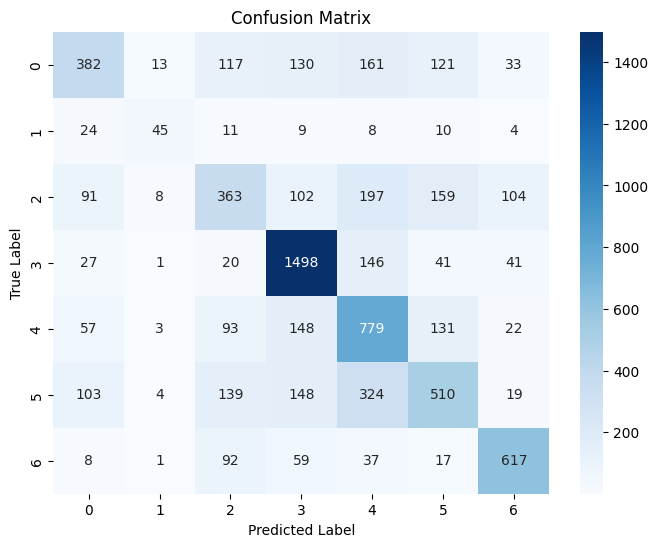

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Your existing code to get true_labels, predicted_labels, and create confusion matrix
true_labels = test_data.classes
predicted_labels = model.predict(test_data).argmax(axis=1)
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap with numerical values
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)

# Add labels
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

plt.show()